In [40]:
import pickle
from dataclasses import dataclass

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

In [41]:
MOISTURE_NUM_STEPS = 16
AMMONIUM_NUM_STEPS = 10
NITRATE_NUM_STEPS = 25
PROBABILITY_OF_CLEAR_FORECAST = 0.405224

In [42]:
weights_for_pareto = np.zeros([2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.float64)
weights_for_pareto[:, 0, 0:2, 0:5] = 0.05
weights_for_pareto[:, 1, 0:2, 0:5] = 0.33
weights_for_pareto[:, 2, 0:2, 0:5] = 0.18
weights_for_pareto[:, 3, 0:2, 0:5] = 0.15
weights_for_pareto[:, 4, 0:2, 0:5] = 0.15
weights_for_pareto[:, 5, 0:2, 0:5] = 0.14
weights_for_pareto[0] *= PROBABILITY_OF_CLEAR_FORECAST
weights_for_pareto[1] *= (1 - PROBABILITY_OF_CLEAR_FORECAST)
weights_for_pareto /= np.sum(weights_for_pareto)

In [43]:
leaching_penalties_USD_per_m2 = np.linspace(0, 1.0734245700734262, 50)
leaching_penalties_USD_per_m2

array([0.        , 0.02190662, 0.04381325, 0.06571987, 0.0876265 ,
       0.10953312, 0.13143974, 0.15334637, 0.17525299, 0.19715961,
       0.21906624, 0.24097286, 0.26287949, 0.28478611, 0.30669273,
       0.32859936, 0.35050598, 0.37241261, 0.39431923, 0.41622585,
       0.43813248, 0.4600391 , 0.48194573, 0.50385235, 0.52575897,
       0.5476656 , 0.56957222, 0.59147884, 0.61338547, 0.63529209,
       0.65719872, 0.67910534, 0.70101196, 0.72291859, 0.74482521,
       0.76673184, 0.78863846, 0.81054508, 0.83245171, 0.85435833,
       0.87626496, 0.89817158, 0.9200782 , 0.94198483, 0.96389145,
       0.98579807, 1.0077047 , 1.02961132, 1.05151795, 1.07342457])

In [44]:
@dataclass
class ParetoOutcomes:
    expected_profit_by_initial_state: npt.NDArray[np.float64] # dimensions: fine, forecast, moisture, ammonium, nitrate
    probability_of_violation_by_initial_state: npt.NDArray[np.float64] # dimensions: fine, forecast, moisture, ammonium, nitrate
    average_profits: npt.NDArray[np.float64] # 1D, fine
    average_probability_of_violation: npt.NDArray[np.float64] #1D, fine
    average_pre_fine_profits: npt.NDArray[np.float64] # 1D, fine

    def __init__(self, expected_profit_by_initial_state, probability_of_violation_by_initial_state):
        self.expected_profit_by_initial_state = expected_profit_by_initial_state
        self.probability_of_violation_by_initial_state = probability_of_violation_by_initial_state
        self.average_profits = np.average(expected_profit_by_initial_state, axis=(1, 2, 3, 4), weights=weights_for_pareto)
        self.average_probability_of_violation = np.average(probability_of_violation_by_initial_state, axis=(1, 2, 3, 4), weights=weights_for_pareto)
        self.average_pre_fine_profits = self.average_profits + (self.average_probability_of_violation * leaching_penalties_USD_per_m2)

In [45]:
pareto_outcomes_by_num_control_steps = {}

In [46]:
with open("36_pareto_sweep_expected_profit.pickle", "rb") as f:
    single_application_pareto_expected_profits = pickle.load(f)
with open("36_pareto_sweep_probability_of_violation.pickle", "rb") as f:
    single_application_pareto_probability_of_violation = pickle.load(f)
pareto_outcomes_by_num_control_steps[1] = ParetoOutcomes(single_application_pareto_expected_profits, single_application_pareto_probability_of_violation)

In [47]:
with open("9_pareto_sweep_expected_profit.pickle", "rb") as f:
    x4_application_pareto_expected_profits = pickle.load(f)
with open("9_pareto_sweep_probability_of_violation.pickle", "rb") as f:
    x4_application_pareto_probability_of_violation = pickle.load(f)
pareto_outcomes_by_num_control_steps[4] = ParetoOutcomes(x4_application_pareto_expected_profits, x4_application_pareto_probability_of_violation)

In [48]:
with open("3_pareto_sweep_expected_profit.pickle", "rb") as f:
    max_application_pareto_expected_profits = pickle.load(f)
with open("3_pareto_sweep_probability_of_violation.pickle", "rb") as f:
    max_application_pareto_probability_of_violation = pickle.load(f)
pareto_outcomes_by_num_control_steps[12] = ParetoOutcomes(max_application_pareto_expected_profits, max_application_pareto_probability_of_violation)

In [49]:
# with open("pareto_sweep_expected_profit.pickle", "rb") as f:
#     x4_application_pareto_expected_profits = pickle.load(f)
# with open("pareto_sweep_probability_of_violation.pickle", "rb") as f:
#     x4_application_pareto_probability_of_violation = pickle.load(f)
# pareto_outcomes_by_num_control_steps[4] = ParetoOutcomes(x4_application_pareto_expected_profits, x4_application_pareto_probability_of_violation)

In [60]:
pareto_outcomes_by_num_control_steps[1].average_probability_of_violation[0]

np.float64(0.6665010749999999)

In [50]:
CHOSEN_FINE_IDX = 9

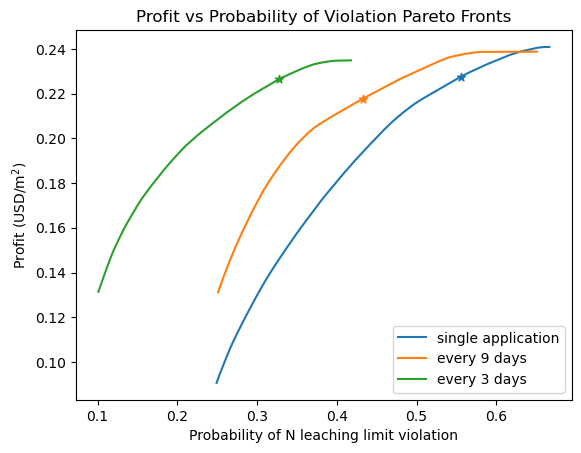

In [51]:
for key, value in pareto_outcomes_by_num_control_steps.items():
    label = "single application" if key == 1 else "every {:d} days".format(int(36 / key))
    plt.plot(value.average_probability_of_violation, value.average_pre_fine_profits, label=label)
    plt.scatter(value.average_probability_of_violation[CHOSEN_FINE_IDX], value.average_pre_fine_profits[CHOSEN_FINE_IDX], marker="*")
plt.title("Profit vs Probability of Violation Pareto Fronts")
plt.ylabel("Profit (USD/$\\text{m}^2$)")
plt.xlabel("Probability of N leaching limit violation")
plt.legend(loc="lower right")

In [52]:
for i in range(len(leaching_penalties_USD_per_m2) - 1):
    if (pareto_outcomes_by_num_control_steps[4].average_probability_of_violation[i] > pareto_outcomes_by_num_control_steps[4].average_probability_of_violation[i + 1]) and (pareto_outcomes_by_num_control_steps[4].average_pre_fine_profits[i] < pareto_outcomes_by_num_control_steps[4].average_pre_fine_profits[i + 1]):
        print("{} is better than {}, {:.2f}% vs {:.2f}% probability of violation and ${:.3f} vs ${:.3f} pre-fine profit".format(i + 1, i, pareto_outcomes_by_num_control_steps[4].average_probability_of_violation[i + 1] * 100.0, pareto_outcomes_by_num_control_steps[4].average_probability_of_violation[i] * 100.0, pareto_outcomes_by_num_control_steps[4].average_pre_fine_profits[i + 1], pareto_outcomes_by_num_control_steps[4].average_pre_fine_profits[i]))

In [53]:
for key, value in pareto_outcomes_by_num_control_steps.items():
    for profit_idx, profit in enumerate(value.average_pre_fine_profits):
        if profit/max(value.average_pre_fine_profits) <= 0.95:
            print(profit_idx, leaching_penalties_USD_per_m2[profit_idx])
            break

9 0.19715961491144562
8 0.1752529910323961
10 0.21906623879049514


In [54]:
leaching_penalties_USD_per_m2[CHOSEN_FINE_IDX]

np.float64(0.19715961491144562)

In [61]:
for key, value in pareto_outcomes_by_num_control_steps.items():
    print("x{} optimal operating leaching violation: {:.2f}, profit: {:.3f}".format(key, value.average_probability_of_violation[CHOSEN_FINE_IDX], value.average_pre_fine_profits[CHOSEN_FINE_IDX]))
    print("\t as percent of max: {:.2f}, profit: {:.3f}".format(value.average_probability_of_violation[CHOSEN_FINE_IDX] / pareto_outcomes_by_num_control_steps[1].average_probability_of_violation[0], value.average_pre_fine_profits[CHOSEN_FINE_IDX] / pareto_outcomes_by_num_control_steps[1].average_profits[0]))

x1 optimal operating leaching violation: 0.56, profit: 0.228
	 as percent of max: 0.83, profit: 0.945
x4 optimal operating leaching violation: 0.43, profit: 0.218
	 as percent of max: 0.65, profit: 0.904
x12 optimal operating leaching violation: 0.33, profit: 0.226
	 as percent of max: 0.49, profit: 0.940


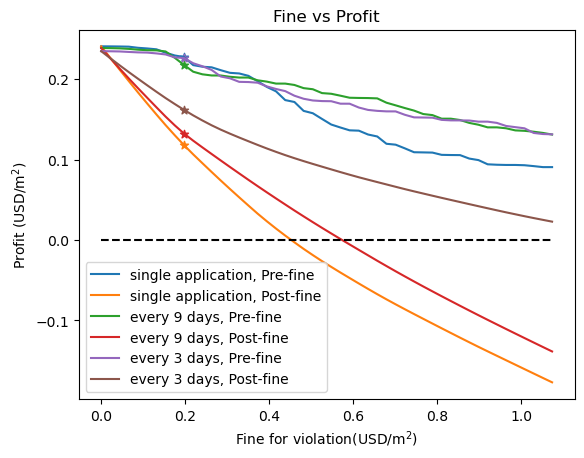

In [63]:
for key, value in pareto_outcomes_by_num_control_steps.items():
    label = "single application" if key == 1 else "every {:d} days".format(int(36 / key))
    plt.plot(leaching_penalties_USD_per_m2, value.average_pre_fine_profits, label=label + ", Pre-fine")
    plt.scatter(leaching_penalties_USD_per_m2[CHOSEN_FINE_IDX], value.average_pre_fine_profits[CHOSEN_FINE_IDX], marker="*")
    plt.plot(leaching_penalties_USD_per_m2, value.average_profits, label=label + ", Post-fine")
    plt.scatter(leaching_penalties_USD_per_m2[CHOSEN_FINE_IDX], value.average_profits[CHOSEN_FINE_IDX], marker="*")
plt.title("Fine vs Profit")
plt.ylabel("Profit (USD/$\\text{m}^2$)")
plt.xlabel("Fine for violation(USD/$\\text{m}^2$)")
plt.hlines([0.0], xmin=0.0, xmax=max(leaching_penalties_USD_per_m2), color="black", linestyles="dashed")
plt.legend(loc="lower left")

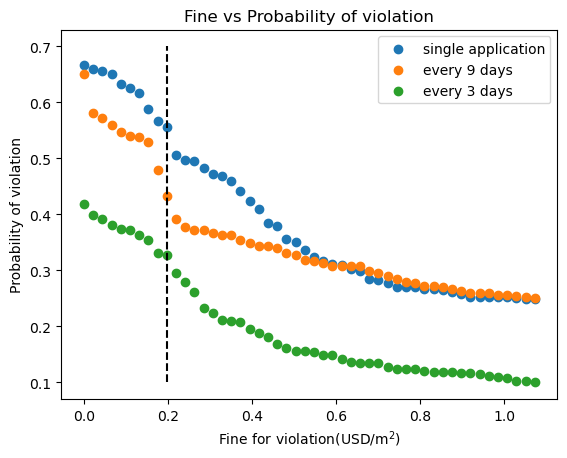

In [64]:
for key, value in pareto_outcomes_by_num_control_steps.items():
    label = "single application" if key == 1 else "every {:d} days".format(int(36 / key))
    plt.scatter(leaching_penalties_USD_per_m2, value.average_probability_of_violation, label=label)
plt.vlines([leaching_penalties_USD_per_m2[CHOSEN_FINE_IDX]], ymin=0.1, ymax=0.7, color="black", linestyle="dashed")
plt.title("Fine vs Probability of violation")
plt.ylabel("Probability of violation")
plt.xlabel("Fine for violation(USD/$\\text{m}^2$)")
plt.legend(loc="upper right")

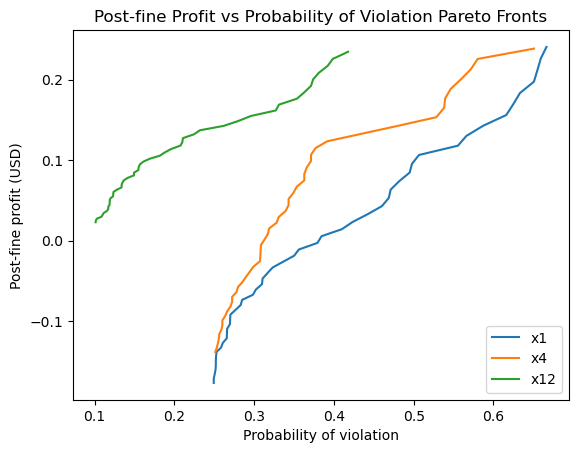

In [58]:
for key, value in pareto_outcomes_by_num_control_steps.items():
    plt.plot(value.average_probability_of_violation, value.average_profits, label="x" + str(key))
plt.title("Post-fine Profit vs Probability of Violation Pareto Fronts")
plt.ylabel("Post-fine profit (USD)")
plt.xlabel("Probability of violation")
plt.legend(loc="lower right")

In [59]:
print("Maximum profit without leaching concerns")
for key, value in pareto_outcomes_by_num_control_steps.items():
    print("x{}: \t{}".format(key, value.average_profits[0]))

Maximum profit without leaching concerns
x1: 	0.2408437637397933
x4: 	0.23874495692472408
x12: 	0.23482122992319915
